# Recommender System


Introduction
--
A general recommender system is presented which employs a collaborative filtering (cofi) model to predict user ratings on a range of products. The current study focuses on user ratings of board games from boardgamegeek.com. The model is contained within cofi.py which should be referenced for details on specific functions. 

---

The Data
--    
The data used in this study is the elite-users dataset: a sparse matrix which contains 199 users in the 1st dimension and 402 board games in the 2nd dimension. This dataset is a subset of two larger datasets which are explored in subsequent studies. The elite-users dataset includes only users who have rated at least 268 board games. The matrix is sparse because not every user has rated every game. Matrix elements that correspond to games which a user has not yet rated are left blank. The sparse, raw data matrix is randomly split into a training dataset and a cross-validation (cv) dataset. The model uses the training dataset to "learn" about the games and users. The cross-validation dataset is used to test the model's ability to predict ratings for games which users have not yet rated, thereby providing a performance metric.

The Model
--
The cofi model begins by generating two random parameter matrices, X and Theta. X is a [users x features] matrix which contains a parameter vector for every user. The user parameter vectors can be thought of as user "profiles" which the model uses to describe each user. Theta is a [games x features] matrix which can be similarly thought of as consisting of game parameter vectors or "profiles". The product of these two matrices gives a ratings matrix with a rating for every user-game combination. The model optimizes X and Theta to produce ratings that are close to the training data. 

The cost function (cofi.cost_f) is defined by the square error between the predicted ratings and the actual ratings. Two regularization terms are included in the total cost function when a regularization value (Lambda) is specified. Regularization serves to prevent overfitting of the training data (high variance). Given values for the number of features and Lambda, the model finds optimal values for X and Theta that minimize the square error between predicted ratings and actual ratings, thereby minimizing the cost function. The optimization function employed is fmin_cg from the scipy.optimize library. 

The optimized model is then used to make predictions on data from the cross-validation dataset which it has never seen before. The cost function can then again be calculated to judge how well the model is able to generalize to new data.

---

Conclusions
--
The recommender system can very accurately fit the training data but fails to generalize to new data. The study finds the model is suffering from overfitting or high variance. The overfitting problem cannot be significantly improved by varying the two hyper parameters N_feature and Lambda. However, a study of the learning curves suggest the overfitting can be improved by supplying the model with more training data. This will be explored in the future by applying the model to the much larger frequent-users dataset. 

---

---

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import cofi
from scipy.optimize import fmin_cg
import matplotlib.pyplot as plt
from IPython.display import display
import pylab
%matplotlib inline

---
First, the raw data is explored.

---

In [2]:
# Create raw data table
data = pd.read_csv('boardgame-elite-users.csv')
data.columns = ['user', 'game', 'rating']

original_data = data.pivot(index='user', columns='game', values='rating')
display(original_data.shape)
original_data.head()

(199, 402)

game,3,5,10,11,12,13,18,41,42,45,...,187645,192291,193738,194655,198773,201808,204583,205059,205637,209010
user,,,,,,,,,,,,,,,,,,,,,
272,1.0,1.0,1.0,NaN,1.0,7.5,1.0,4.0,1.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
388,8.0,7.0,8.0,8.0,8.0,7.0,8.0,9.0,9.0,8.0,...,NaN,NaN,9.0,8.0,NaN,8.0,7.0,10.0,8.0,8.0
430,6.0,6.0,7.0,7.0,6.0,8.0,NaN,5.0,6.0,9.0,...,8.0,NaN,7.5,NaN,NaN,NaN,NaN,9.0,9.0,NaN
2044,8.0,7.0,7.0,7.0,NaN,8.0,7.0,7.0,7.0,6.0,...,7.0,8.0,8.0,NaN,9.0,8.0,7.5,8.5,7.0,7.0
3080,9.0,NaN,5.0,8.0,7.0,8.0,8.0,7.0,8.0,9.0,...,9.0,NaN,NaN,9.0,8.0,NaN,9.0,9.0,9.0,8.0


Text(0.5,1,'Distribution of User Ratings')

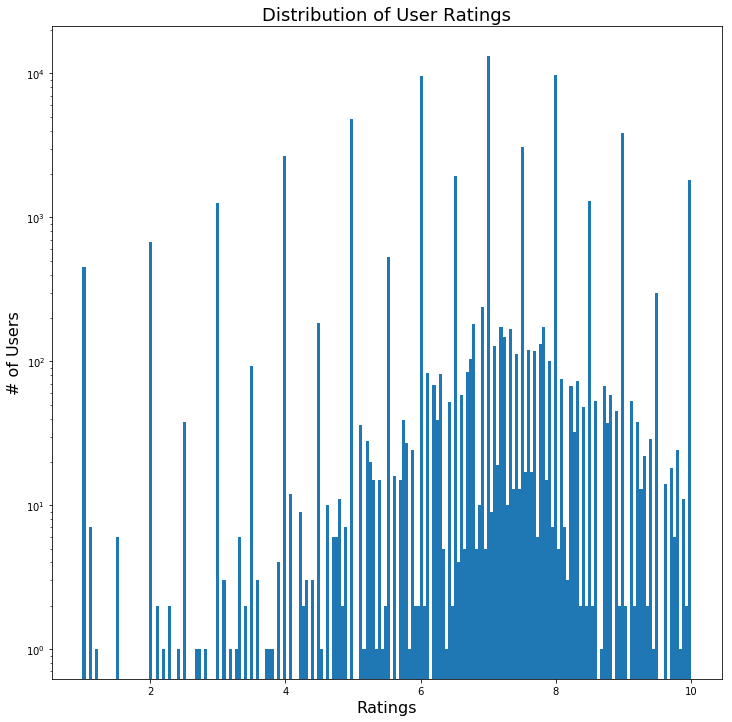

In [3]:
# Plot distribution of original data
pylab.rcParams['figure.figsize'] = (12,12)
plt.hist(data['rating'], 200)
plt.yscale('log', nonposy='clip')
plt.xlabel('Ratings', fontsize=16)
plt.ylabel('# of Users', fontsize=16)
plt.title('Distribution of User Ratings', fontsize=18)

In [4]:
print('Median: ' + str(np.median(data['rating'])))
print('Mean: ' + str(np.mean(data['rating'])))

Median: 7.0
Mean: 6.781509247297347


---
The raw data is shown in the semilog histogram above. The data is clearly quantized with the largest ratings bins located at integer ratings, followed by half and quarter integer ratings. The median and mean ratings are 7.0 and 6.8, respectively.

---

In [5]:
# Remove a random subset of the data to use for cross-validation
X_cv = data.sample(frac=0.2)

# Blank the corresponding data in the training set.
X_train = data.copy()
X_train.loc[X_cv.index, 'rating'] = np.nan

X_train = X_train.pivot(index='user', columns='game', values='rating')
X_cv = X_cv.pivot(index='user', columns='game', values='rating')

In [6]:
# X_train is the training dataset
X_train.head()

game,3,5,10,11,12,13,18,41,42,45,...,187645,192291,193738,194655,198773,201808,204583,205059,205637,209010
user,,,,,,,,,,,,,,,,,,,,,
272,1.0,1.0,1.0,NaN,1.0,NaN,1.0,4.0,1.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
388,8.0,NaN,8.0,NaN,NaN,7.0,8.0,9.0,9.0,8.0,...,NaN,NaN,9.0,8.0,NaN,8.0,7.0,10.0,NaN,8.0
430,6.0,6.0,NaN,NaN,6.0,8.0,NaN,NaN,6.0,NaN,...,NaN,NaN,7.5,NaN,NaN,NaN,NaN,9.0,9.0,NaN
2044,8.0,7.0,7.0,7.0,NaN,8.0,7.0,7.0,7.0,6.0,...,7.0,8.0,8.0,NaN,9.0,8.0,7.5,8.5,7.0,7.0
3080,9.0,NaN,5.0,NaN,NaN,8.0,8.0,7.0,8.0,9.0,...,9.0,NaN,NaN,9.0,NaN,NaN,9.0,9.0,9.0,8.0


In [7]:
# X_cv is the cross-validation dataset
X_cv.head()

game,3,5,10,11,12,13,18,41,42,45,...,187645,192291,193738,194655,198773,201808,204583,205059,205637,209010
user,,,,,,,,,,,,,,,,,,,,,
272,NaN,NaN,NaN,NaN,NaN,7.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
388,NaN,7.0,NaN,8.0,8.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN
430,NaN,NaN,7.0,7.0,NaN,NaN,NaN,5.0,NaN,9.0,...,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,NaN,NaN,NaN,8.0,7.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN


---
After setting up the training and cross-validation data sets, we will train the collaborative filtering model defined in "cofi.py" on the training data set. First, we call the get_args function that generates all of the arguments we'll need for the subsequent functions called in the model. This includes initializing the random matrices X and Theta that will contain our user and movie parameters for predicting ratings, as well as N_features, N_games, and N_users. The unroll_parameters function is then called to unroll, and then stack the X and Theta matrices into a single vector. This is necessary because the optimization function we will use (fmin_cg from the scipy library.optimize) requires a 1-dimensional vector as its input. The optimized parameters are then used to generate predicted ratings for all user and movie combinations. To start, we will arbitrarily choose N_features=350 and Lambda=1. 

---

In [8]:
# Make an initial prediction using the model and compare to the training data.
args = cofi.get_args(X_train, N_features=250, Lambda=1)
parameters = cofi.unroll_params(args[0], args[2])

results = fmin_cg(cofi.cost_f, parameters, cofi.grad_f, args=args, 
                 full_output=True, maxiter=100)

X_opt, Theta_opt = cofi.roll_params(results[0], *args)

predictions = np.dot(Theta_opt, X_opt.T)
predictions = pd.DataFrame(predictions, index=X_train.index, columns=X_train.columns)
predictions = predictions.add(args[7], axis=1)
predictions.head()

         Current function value: 3296.320122
         Iterations: 100
         Function evaluations: 141
         Gradient evaluations: 141


game,3,5,10,11,12,13,18,41,42,45,...,187645,192291,193738,194655,198773,201808,204583,205059,205637,209010
user,,,,,,,,,,,,,,,,,,,,,
272,1.086560,1.073597,1.032708,2.455835,1.097215,3.819284,1.069976,3.913088,1.077529,5.944926,...,3.412529,3.261544,3.637535,3.199626,3.556470,3.866247,4.543504,2.628190,5.322140,3.344489
388,8.039910,7.891732,7.974095,7.686472,7.411966,7.136869,7.954133,8.929262,8.948167,7.975350,...,7.899359,7.727313,9.041705,8.032128,7.994030,8.025212,6.998712,9.851629,8.611377,8.083071
430,6.034970,6.020785,6.420450,4.848673,6.026874,7.917956,6.279878,6.503274,6.003553,7.138359,...,7.679888,6.287457,7.463211,6.014342,5.928287,6.576891,6.006477,8.934073,8.950334,6.430470
2044,7.978584,7.015441,6.937296,7.054971,8.204798,7.986367,6.972763,7.037526,7.072227,6.111904,...,7.019930,7.951802,7.979344,7.319609,8.851672,7.975813,7.486322,8.436276,7.059344,7.120106
3080,8.917484,6.664810,5.106511,7.102301,7.756380,7.980269,7.961024,7.032115,8.001077,8.953228,...,8.965640,7.075572,7.576904,8.973984,8.146326,8.301466,8.950532,8.980191,8.985494,8.008777


---
Once we have successfully made predictions, we can see how well the model fits the training data by plotting all of the model's predictions against the actual values.

---

# of data points: 47434


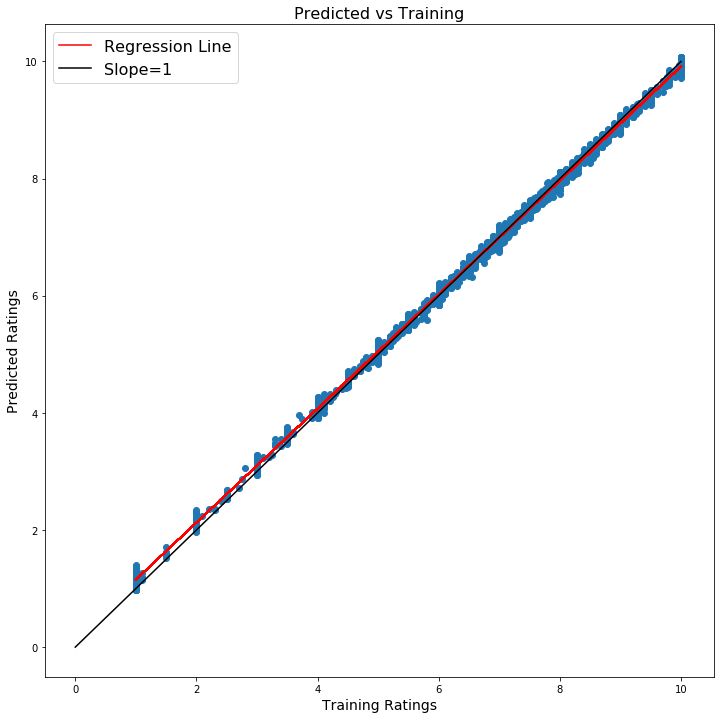

In [9]:
# Plot the model's predictions against the actual training data
predicted_data = np.array([])
for user in X_train.index:
    predicted_data = np.append(predicted_data, predictions.loc[user,:])
    
training_data = np.array([])
for user in X_train.index:
    training_data = np.append(training_data, X_train.loc[user,:])
    
# Draw regression line
idx1 = np.isfinite(training_data) & np.isfinite(predicted_data)
fit1 = np.polyfit(training_data[idx1], predicted_data[idx1], 1)    

fig1, ax1 = plt.subplots()

ax1.plot(training_data, fit1[0]*training_data + fit1[1], color='red')
ax1.plot(np.linspace(0,10,11), color='black')
ax1.scatter(training_data, predicted_data)

plt.legend(['Regression Line', 'Slope=1'], fontsize=16)
plt.xlabel('Training Ratings', fontsize=14)
plt.ylabel('Predicted Ratings', fontsize=14)
plt.title('Predicted vs Training', fontsize=16)
print('# of data points: ' + str(training_data.size - np.count_nonzero(np.isnan(training_data))))

---
If the model fit the training data perfectly, all points in the plot above would lie exactly on the black line of slope 1 and 0 intercept. Instead, there is some spread in our model's predictions. The red line shows a linear regression on the blue data points.  

The ultimate goal here is not to fit the training data perfectly, but to make accurate predictions on data that the model hasn't seen before (cross-validation dataset). As such, the initial values of N_features=250 and Lambda=1 gives us a "good enough" fit on the training data for now. 

---

# of data points: 11859


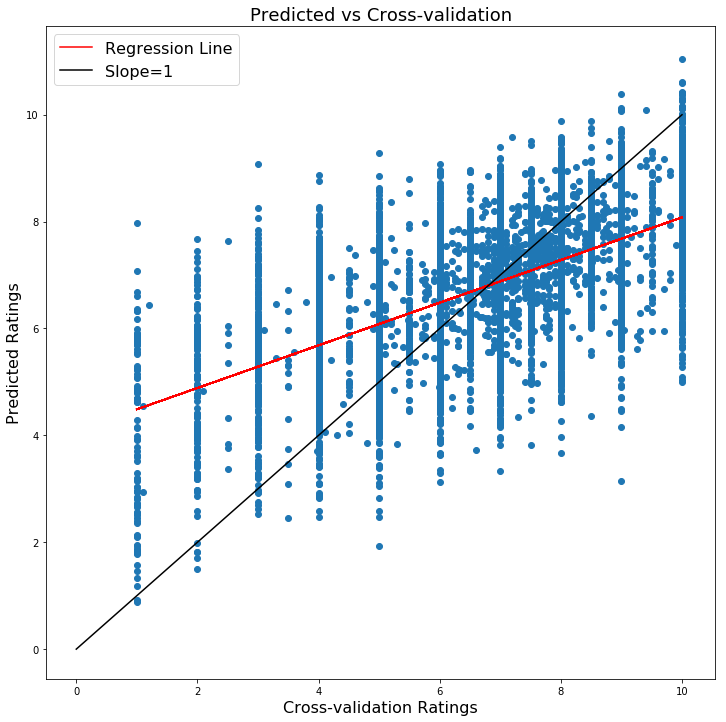

In [10]:
# Now compare the model's predictions on the cross-validation data.
predicted_data_cv = np.array([])
for user in X_cv.index:
    predicted_data_cv = np.append(predicted_data_cv, predictions.loc[user,:])
    
cv_data = np.array([])
for user in X_cv.index:
    cv_data = np.append(cv_data, X_cv.loc[user,:])
    
# Draw regression line
idx = np.isfinite(cv_data) & np.isfinite(predicted_data_cv)
fit = np.polyfit(cv_data[idx], predicted_data_cv[idx], 1)

fig, ax = plt.subplots()

ax.plot(cv_data, fit[0]*cv_data + fit[1], color='red')
ax.plot(np.linspace(0,10,11), color='black')
ax.scatter(cv_data, predicted_data_cv)

plt.legend(['Regression Line', 'Slope=1'], fontsize=16)
plt.xlabel('Cross-validation Ratings', fontsize=16)
plt.ylabel('Predicted Ratings', fontsize=16)
plt.title('Predicted vs Cross-validation', fontsize=18)
print('# of data points: ' + str(cv_data.size - np.count_nonzero(np.isnan(cv_data))))

---
The plot above shows a much larger error in the model's predictions on the cv dataset. The general trend of the data looks right, however the large vertical spread in the predicted ratings indicates the model is largely inaccurate. Furthermore, compare the regression line (red) to the ideal black line; It appears the model significantly overestimates low ratings (0-5), whereas it begins to underestimate at higher ratings (5-10).

The model's ability fit the training data well but not the cv data is often indicative of overfitting such that the model cannot generalize well to new data. Next, we can look at how the cost functions J_train and J_cv depend on the hyper parameters N_feature and Lambda. This will help us choose values of N_feature and Lambda that minimize J_cv and hopefully reduce overfitting.

---

In [11]:
%%time
# Compute J_train & J_cv vs lambda for various N_features
N_min = 150
N_max = 400
N_range = np.arange(N_min, N_max+1, 50)
lambda_min = 0
lambda_max = 5
lambda_range = np.logspace(lambda_min, lambda_max,10)*0.0001

# The J_train & J_cv matrices will store the cost of our
# predictions for each combination of lambda and N_feature
J_train_N = np.zeros((len(N_range), len(lambda_range)))
J_cv_N = np.zeros((len(N_range), len(lambda_range)))

# min_lambdas will store the value of lambda that minimizes
# the error for each value of N_features.
min_lambdas = np.zeros(len(N_range))

for n in range(len(N_range)):
    
    N_features = N_range[n]
    print('N_features: ' + str(N_features))
    
    # J_train & J_cv are arrays that will store the cost for
    # each value of lambda at a fixed N_feature (above).
    J_train = np.zeros(len(lambda_range))
    J_cv = J_train.copy()
    
    for l in range(len(lambda_range)):
        Lambda = lambda_range[l]
        print('\n Lambda: ' + str(Lambda))

        args_train = cofi.get_args(X_train, N_features=N_features, Lambda=Lambda)
        init_params = cofi.unroll_params(args_train[0], args_train[2])

        result = fmin_cg(cofi.cost_f, init_params, cofi.grad_f, 
                        args=args_train, full_output=True, maxiter=100)
        cost_train = result[1]

        args_cv = cofi.get_args(X_cv, N_features=N_features, Lambda=Lambda)
        cost_cv = cofi.cost_f(result[0], *args_cv)

        J_train[l] = cost_train
        J_cv[l] = cost_cv
        
    J_train_N[n] = J_train
    J_cv_N[n] = J_cv

    L = {'Lambda':lambda_range, 'J_train':J_train, 'J_cv':J_cv}
    summary = pd.DataFrame(L, columns=['Lambda', 'J_train', 'J_cv'])
    min_lambdas[n] = summary[summary['J_cv'] == min(summary['J_cv'])]['Lambda']

N_features: 150

 Lambda: 0.0001
         Current function value: 0.474143
         Iterations: 100
         Function evaluations: 157
         Gradient evaluations: 157

 Lambda: 0.00035938136638
         Current function value: 1.710659
         Iterations: 100
         Function evaluations: 144
         Gradient evaluations: 144

 Lambda: 0.00129154966501
         Current function value: 5.872226
         Iterations: 100
         Function evaluations: 160
         Gradient evaluations: 160

 Lambda: 0.00464158883361
         Current function value: 21.086912
         Iterations: 100
         Function evaluations: 163
         Gradient evaluations: 163

 Lambda: 0.016681005372
         Current function value: 70.831475
         Iterations: 100
         Function evaluations: 156
         Gradient evaluations: 156

 Lambda: 0.0599484250319
         Current function value: 234.890722
         Iterations: 100
         Function evaluations: 150
         Gradient evaluations: 150

 Lambda:

         Current function value: 2569.790156
         Iterations: 100
         Function evaluations: 147
         Gradient evaluations: 147

 Lambda: 2.78255940221
         Current function value: 8700.273724
         Iterations: 100
         Function evaluations: 150
         Gradient evaluations: 150

 Lambda: 10.0
         Current function value: 25141.481017
         Iterations: 100
         Function evaluations: 153
         Gradient evaluations: 153
N_features: 350

 Lambda: 0.0001
         Current function value: 0.696121
         Iterations: 100
         Function evaluations: 175
         Gradient evaluations: 175

 Lambda: 0.00035938136638
         Current function value: 2.628464
         Iterations: 100
         Function evaluations: 162
         Gradient evaluations: 162

 Lambda: 0.00129154966501
         Current function value: 9.170938
         Iterations: 100
         Function evaluations: 160
         Gradient evaluations: 160

 Lambda: 0.00464158883361
         Curren


Optimal lambda = 0.0599
Optimal N_feature = 350


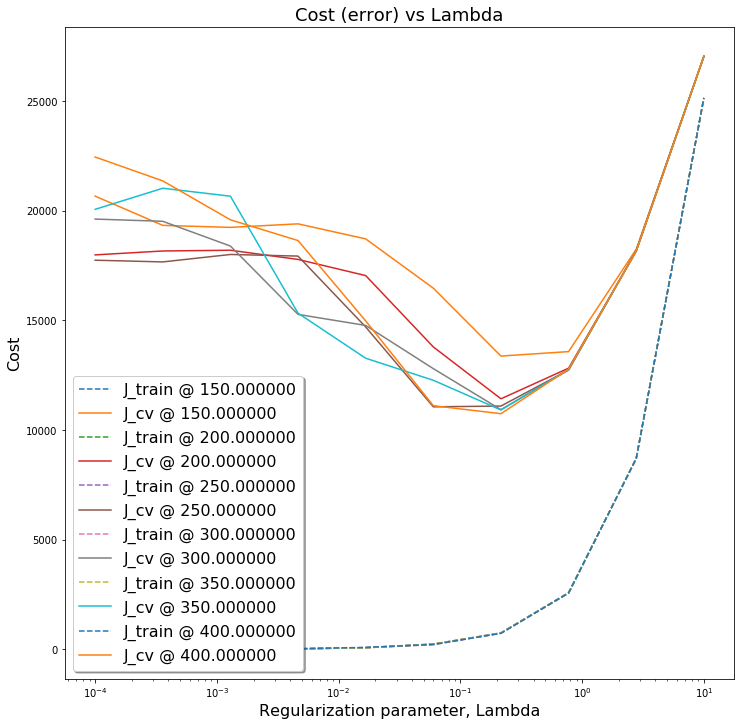

In [12]:
# Plot results
for n in range(len(N_range)):
    train, = plt.plot(lambda_range,J_train_N[n], label='J_train @ %f' % N_range[n],linestyle='--')
    test, = plt.plot(lambda_range,J_cv_N[n], label='J_cv @ %f' % N_range[n])

plt.legend(loc='lower left', shadow=True, fontsize=16)
plt.xscale('log')
plt.xlabel('Regularization parameter, Lambda', fontsize=16)
plt.ylabel('Cost', fontsize=16)
plt.title('Cost (error) vs Lambda', fontsize=18)

print() # New line
print('Optimal lambda = %2.4f' % min(min_lambdas))
print('Optimal N_feature = %i' % 350)

---
The plot above shows the cost function of the model on both the training and cv data vs Lambda, for several values of N_features. J_train (dashed lines) seems to be independent of N_features and scales with Lambda. J_cv gets large for very small and large values of Lambda, with a minimum between 0.01 and 0.1 for all values of N_features. From this survey, the optimal values of N_feature and lambda that minimize J_cv are N_feature=350 and Lambda=0.22. Interestingly, under the conditions that minimize J_cv, there still exists a large gap in the cost functions of J_cv and J_train. It appears that there is still some overfitting in the model. Ideally, we want to minimize this gap to render the model more general or robust to new data.

In addition to the regularization parameter Lambda and N_features, another way to overcome overfitting is to increase the size of the training data available for the recommender system to train on. This is because with more data, there is more comprehensive information which gives the model a better chance at seeing all the different types of users and movies and therefore becoming more generalized.

To understand the effect of sample size on the model, we can plot the learning curves.

---

In [13]:
# For a fixed value of N_features & Lambda, compute J_cv as a function of sample size
X_cv_m = data.sample(frac=0.2)

X_train_m = data.copy()
X_train_m.loc[X_cv_m.index, 'rating'] = np.nan

X_cv_m = X_cv_m.pivot(index='user', columns='game', values='rating')

m = np.linspace(0.1, 1, 10)
      
J_train_m = np.zeros(len(m))
J_cv_m = J_train_m.copy()

for s in range(len(m)):
    frac = 1-m[s]
    print(frac)

    X_blank = X_train_m.sample(frac=frac) # Get random sample of cells to blank

    X_frac = X_train_m.copy()
    X_frac.loc[X_blank.index, 'rating'] = np.nan
    X_frac = X_frac.pivot(index='user', columns='game', values='rating')

    N_features = 350
    Lambda = 0.22

    args_train = cofi.get_args(X_frac, N_features=N_features, Lambda=Lambda)
    init_params = cofi.unroll_params(args_train[0], args_train[2])

    result = fmin_cg(cofi.cost_f, init_params, cofi.grad_f, 
                    args=args_train, full_output=True, maxiter=100)
    cost_train = result[1]

    args_cv = cofi.get_args(X_cv_m, N_features=N_features, Lambda=Lambda)
    cost_cv = cofi.cost_f(result[0], *args_cv)

    J_train_m[s] = cost_train
    J_cv_m[s] = cost_cv

0.9
         Current function value: 200.918866
         Iterations: 100
         Function evaluations: 162
         Gradient evaluations: 162
0.8
         Current function value: 298.447720
         Iterations: 100
         Function evaluations: 155
         Gradient evaluations: 155
0.7
         Current function value: 378.383124
         Iterations: 100
         Function evaluations: 154
         Gradient evaluations: 154
0.6
         Current function value: 442.522739
         Iterations: 100
         Function evaluations: 156
         Gradient evaluations: 156
0.5
         Current function value: 502.620333
         Iterations: 100
         Function evaluations: 150
         Gradient evaluations: 150
0.4
         Current function value: 563.837575
         Iterations: 100
         Function evaluations: 151
         Gradient evaluations: 151
0.3
         Current function value: 619.690649
         Iterations: 100
         Function evaluations: 157
         Gradient evaluations: 157

Text(0.5,1,'Learning Curves - Elite Users')

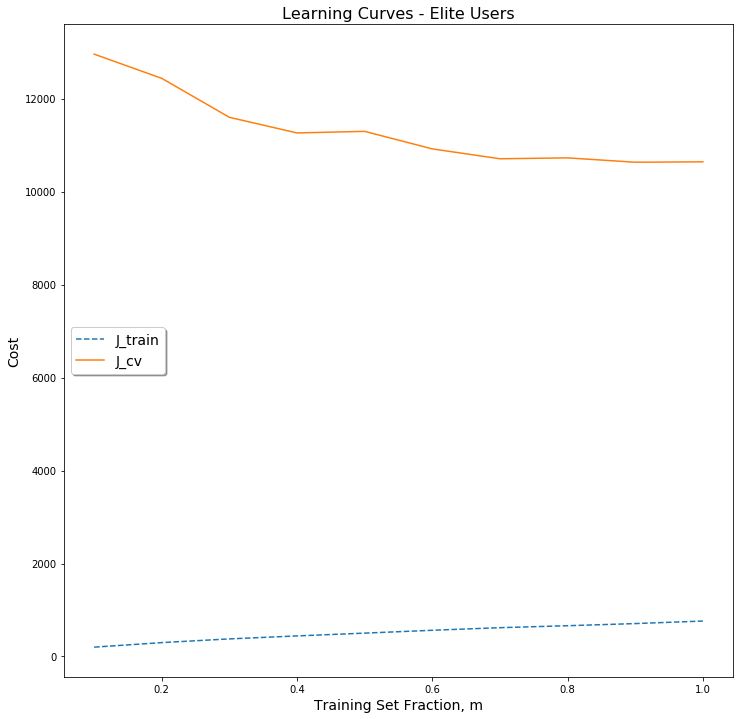

In [14]:
# Plot results
fig, ax = plt.subplots()
ax.plot(m,J_train_m, label='J_train' ,linestyle='--')
ax.plot(m,J_cv_m, label='J_cv')

plt.legend(loc='center left', shadow=True, fontsize=14)
plt.xlabel('Training Set Fraction, m', fontsize=14)
plt.ylabel('Cost', fontsize=14)
plt.title('Learning Curves - Elite Users', fontsize=16)

---
The learning curves in the figure above are generated by training the model on various fractions (m) of the total training data set. J_train and J_cv tend towards each other as the model is given more of the data to train on. The results suggest that the model's high variance can be reduced by providing a larger training dataset.

---

---

# SUPPLEMENTAL

Plot the dependence of J_train and J_cv on N_feature for various values of Lambda.

In [15]:
%%time
# Compute cost vs N_feature for various values of the regularization parameter, Lambda
N_min = 100
N_max = 350
N_range = np.arange(N_min, N_max+1, 50)
lambda_min = 0
lambda_max = 4
lambda_range = np.logspace(lambda_min, lambda_max,10)*0.0001

cost_l = np.zeros((len(lambda_range),len(N_range)))
idx = 0

for l in lambda_range:
    print('lambda = %2.5f' % l)
    print() # new line
    
    cost = np.zeros(len(N_range))
    
    idx2=0
    for i in N_range:
        
        N_features = i
        print(N_features)

        args = cofi.get_args(X_train, N_features=N_features, Lambda=l)
        init_params = cofi.unroll_params(args[0], args[2])

        result = fmin_cg(cofi.cost_f, init_params, cofi.grad_f, 
                        args=args, full_output=True, maxiter=100)
        cost[idx2] = result[1]
        
        idx2 += 1
        
    cost_l[idx] = cost
    idx += 1

lambda = 0.00010

100
         Current function value: 54.220384
         Iterations: 100
         Function evaluations: 153
         Gradient evaluations: 153
150
         Current function value: 0.477527
         Iterations: 100
         Function evaluations: 161
         Gradient evaluations: 161
200
         Current function value: 0.490642
         Iterations: 100
         Function evaluations: 149
         Gradient evaluations: 149
250
         Current function value: 0.546425
         Iterations: 100
         Function evaluations: 160
         Gradient evaluations: 160
300
         Current function value: 0.633866
         Iterations: 100
         Function evaluations: 162
         Gradient evaluations: 162
350
         Current function value: 0.732573
         Iterations: 100
         Function evaluations: 172
         Gradient evaluations: 172
lambda = 0.00028

100
         Current function value: 65.326748
         Iterations: 100
         Function evaluations: 159
         G

         Current function value: 174.874397
         Iterations: 100
         Function evaluations: 158
         Gradient evaluations: 158
lambda = 0.12915

100
         Current function value: 615.149113
         Iterations: 100
         Function evaluations: 152
         Gradient evaluations: 152
150
         Current function value: 473.857148
         Iterations: 100
         Function evaluations: 160
         Gradient evaluations: 160
200
         Current function value: 450.157244
         Iterations: 100
         Function evaluations: 157
         Gradient evaluations: 157
250
         Current function value: 469.894594
         Iterations: 100
         Function evaluations: 150
         Gradient evaluations: 150
300
         Current function value: 469.121481
         Iterations: 100
         Function evaluations: 152
         Gradient evaluations: 152
350
         Current function value: 449.686329
         Iterations: 100
         Function evaluations: 155
         Gradient ev

Text(0.5,0,'N_feature')

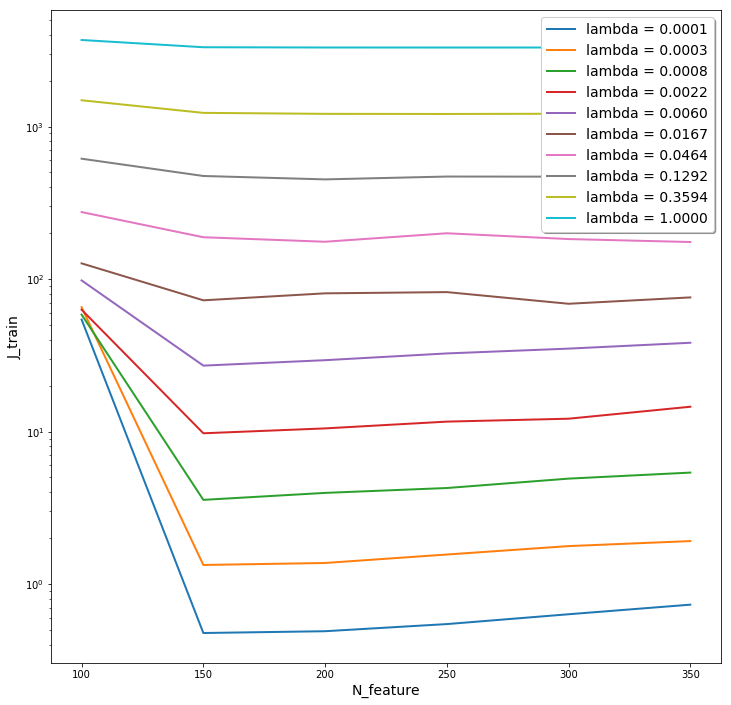

In [16]:
# Plot results
for l in range(len(lambda_range)):
    plt.plot(N_range, cost_l[l], linewidth=2.0, 
             label='lambda = %2.4f' % lambda_range[l])
plt.legend(loc='upper right', shadow=True, fontsize=14)
plt.yscale('log')
plt.ylabel('J_train', fontsize=14)
plt.xlabel('N_feature', fontsize=14)

In [17]:
# Save results to csv files
pd.DataFrame(J_train).to_csv('J_train.csv', index=False)
pd.DataFrame(J_cv).to_csv('J_cv.csv')